## Import Dependencies And Define Paths

In [1]:
! pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np 
import pandas as pd  
# %matplotlib inline
import matplotlib.pyplot as plt
from itertools import chain
from sklearn.metrics import roc_curve, auc
import keras
import tensorflow as tf
import tensorflow_addons as tfa

In [3]:
# Mount your google drive to access the files 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Import Data Files 
rtrain =pd.read_csv("/content/drive/MyDrive/NIH-CXR/train_set.csv")
rtest = pd.read_csv("/content/drive/MyDrive/NIH-CXR/test_set.csv")
rval = pd.read_csv("/content/drive/MyDrive/NIH-CXR/val_set.csv")

In [5]:
def path_fix(df, column, header):
  copy_df = df.copy()
  # Insert the header path for your drive folder
  copy_df[column] = header + copy_df[column].astype(str)
  # Replace the backslashes with forward slashes as a string. \\\\ is for regex purposes
  copy_df[column] = copy_df[column].str.replace("\\\\", "/")
    
  return copy_df

In [6]:
# Function to clean the sets and extract the labels. 

def label_cleaner(raw_df):
    # Copy the Df into two separate dataframes, one for saving as csv and one for output
    copy_df = raw_df.copy()

    # Create a column for categorical labels list in case of use
    copy_df["Labels"] = copy_df["Finding Labels"].replace("No Finding", "").str.split("|", expand = False)
    # Get a list of all diseases 
    di = list(chain(*copy_df["Finding Labels"].replace("No Finding", "").str.split("|", expand = False).tolist()))
    # Drop unnecessary columns from df 
    copy_df.drop(columns = ['Unnamed: 0', 'og_idx'], axis= 1, inplace= True )

    #Extract the list of diseases as a regualr list and as an numpy array because the model likes arrays    
    ls = np.unique(di).tolist()
    ls.remove('')
    np_ls = np.array(ls)

    return copy_df, ls, np_ls


In [7]:
# Define constants for the column name and the path header. 
COL = "path"
HEAD = "/content/drive/MyDrive/NIH-CXR/"

In [8]:
# Fix the paths specific to google drive format 
ftrain = path_fix(rtrain, COL, HEAD)
ftest = path_fix(rtest, COL, HEAD)
fval = path_fix(rval, COL, HEAD)

ftrain.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  


,Unnamed: 0,og_idx,Image Index,Finding Labels,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,29453,44578,00011460_052.png,No Finding,/content/drive/MyDrive/NIH-CXR/images_005/imag...,0,0,0,0,0,0,0,0,0,0,0,0,0
1,33813,50949,00012880_011.png,No Finding,/content/drive/MyDrive/NIH-CXR/images_006/imag...,0,0,0,0,0,0,0,0,0,0,0,0,0
2,32929,49712,00012620_014.png,Effusion,/content/drive/MyDrive/NIH-CXR/images_006/imag...,0,0,0,0,1,0,0,0,0,0,0,0,0
3,11713,17922,00004822_026.png,Atelectasis|Infiltration,/content/drive/MyDrive/NIH-CXR/images_003/imag...,1,0,0,0,0,0,0,1,0,0,0,0,0
4,76383,111882,00030650_007.png,Effusion|Infiltration|Nodule|Pleural_Thickening,/content/drive/MyDrive/NIH-CXR/images_012/imag...,0,0,0,0,1,0,0,1,0,1,1,0,0


In [9]:
train_set, labels, np_labels = label_cleaner(ftrain)
test_set, _, _ = label_cleaner(ftest)
val_set, _, _ = label_cleaner(fval)

print(f"Train Set Shape: {train_set.shape},\nTest Set Shape: {test_set.shape},\nVal Set Shape: {val_set.shape}")

Train Set Shape: (30000, 17),
Test Set Shape: (10000, 17),
Val Set Shape: (10000, 17)


In [10]:
labels

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Infiltration',
 'Mass',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

### Divide X and Y between sets.

In [11]:
# Function to split between x and y 
def xysplitter(df, xcol, ycol): 
  copy_df = df.copy()
  x = copy_df[xcol]
  y = copy_df[ycol]

  return x, y

In [12]:
# Split the sets

xtrain, ytrain = xysplitter(train_set, xcol = 'path', ycol = labels)
xtest, ytest =  xysplitter(test_set, xcol = 'path', ycol = labels)
xval, yval =  xysplitter(val_set, xcol = 'path', ycol = labels)

### Preprocess Image Data Using Custom Preprocessing function

- Image data is preprocessed and fed into the model in batches by iterating through the directories where the images are located. 

- Ideally The images should be sorted into spearate folders but due to the high volume of images to sort, we are using their direct paths as the x variable to feed into the model. 

- The current batching process involves a parse function that decodes the image into a tensor string and performs a histogram equalization to increase the contrast of the edges in the image. Additionally, a guassian filter is applied to introduce some noise into the features to prevent overfitting. 

- Then the images are generated in batches and prefetched in sets of 32 to be fed into the model and augmentation is applied in real time to the training set. The training set is also shuffled as it goes through the epochs. 

- Current batching function adapts the memory allocation using keras' autotune function to ensure that the system does not crash since we are loading large volumes of data. All images are normalized to 0-1 by dividing with 225 and resized to 224 x 224 x 3 to be fed into the model as that is the standard format for ResNet101. 

- Ideally, a dimensionality reduction must be perfromed to reduce the image from RGB to greyscale 224 x 224 x 1 as this refines the features for the machine. Additionally, more preprocessing such as random flips, shears and rotations should also be performed to further prevent overfitting. 

In [13]:
# Import Keras preprocessing layers to introduce into training data augmentation
from keras.layers import RandomFlip, RandomTranslation, RandomRotation, RandomZoom 

In [14]:
# Import Dependencies for the CNN

from keras.applications.resnet import ResNet101
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

In [15]:
# Define Constants for image parameters. 

IMG_SIZE = 224 # Specify height and width of image to match the input format of the model
CHANNELS = 3 # Keep RGB color channels to match the input format of the model

In [16]:
# Function to read the image files and transform them into vectors

def parse_function(filename, label):
    """Function that returns a tuple of normalized image array and labels array.
    Args:
        filename: string representing path to image
        label: 0/1 one-dimensional array of size N_LABELS
    """
    
    # Read an image from a file
    image_string = tf.io.read_file(filename)
    # Decode it into a dense vector
    image_decoded = tf.image.decode_png(image_string, channels=CHANNELS)
    
    # Equalize the Image 
    image_equalized = tfa.image.equalize(image_decoded)
    # Perform Gaussian Filtering of the Image
    image_gaus = tfa.image.gaussian_filter2d(image_equalized)
    
    # Resize it to fixed shape
    image_resized = tf.image.resize(image_gaus, [IMG_SIZE, IMG_SIZE])

    # Normalize it from [0, 255] to [0.0, 1.0]
    image_normalized = image_resized / 255.0
    return image_normalized, label

In [17]:
# Define constants for the batching and shuffling 

BATCH_SIZE = 32 # Big enough to not crash the processor
AUTOTUNE = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically to reduce GPU and CPU idle time
SHUFFLE_BUFFER_SIZE = 256 # Shuffle the training data by a chunck of 256 observations

In [18]:
# This is the Image Augmentation Sequential layer that randomly flips, zooms and rotates images

trainAug = Sequential([
	RandomFlip("horizontal"),
	RandomZoom(
		height_factor=(-0.05, -0.15),
		width_factor=(-0.05, -0.15)),
	RandomRotation(0.05)
])

In [19]:
# Function to Generate the dataset required

def create_dataset(filenames, labels, is_training=True):
    """Load and parse dataset.
    Args:
        filenames: list of image paths
        labels: numpy array of shape (BATCH_SIZE, N_LABELS)
        is_training: boolean to indicate training mode
    """
    
    # Create a first dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))

    # Parse and preprocess observations in parallel
    dataset = dataset.map(parse_function, num_parallel_calls=AUTOTUNE)

    # Perform Image Augmentations as per the Preprocessing layer if it is training set. 
    if is_training == True:
      dataset = dataset.map(lambda x, y: (trainAug(x), y),num_parallel_calls=AUTOTUNE)
      # This is a small dataset, only load it once, and keep it in memory.
      dataset = dataset.cache()
      # Shuffle the data each buffer size
      dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)

        
    # Batch the data for multiple steps
    dataset = dataset.batch(BATCH_SIZE)
    # Fetch batches in the background while the model is training.
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    return dataset

In [20]:
train_ds = create_dataset(xtrain, ytrain)
val_ds = create_dataset(xval, yval, is_training = False)  

In [21]:
# Differential Model Incorporating ResNet101

feature_extractor_layer = ResNet101(input_shape =  (IMG_SIZE,IMG_SIZE,CHANNELS), 
                                 include_top = False, weights = None, pooling = max)

# trainable has to be false in order to freeze the layers
feature_extractor_layer.trainable = True # To fine tune, choose true.  
d_model = Sequential()
d_model.add(feature_extractor_layer)
d_model.add(GlobalAveragePooling2D())
d_model.add(Flatten()) # Flatten out the tensor so that the drop out layer is not processing too much information. 
d_model.add(Dropout(0.5))
d_model.add(Dense(512, activation= 'relu', name='hidden_layer'))
d_model.add(Dropout(0.5))
d_model.add(Dense(13, activation = 'sigmoid', name='output_layer'))
d_model.compile(Adam(learning_rate=1e-4),loss="binary_crossentropy",metrics=['binary_accuracy', 'mae'])
d_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 hidden_layer (Dense)        (None, 512)               1049088   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                      

In [22]:
# Save checkpoints

weights = "weights/{}_weights.best/hdf5".format("modeldelta")

# Save weights of the model every 50 steps. 
checkpoint = ModelCheckpoint(
    weights, monitor="val_loss", 
    verbose = 50, 
    save_best_only = True,
    mode = "min", 
    save_weights_only = True  
)

# Stop the model if the validation loss does not improve by .01 within 2 epochs
stopclock = EarlyStopping(monitor="val_loss", 
                          min_delta = 0.001, 
                          mode="min", 
                          patience=2)



In [23]:
# Train the model 
d_model.fit(train_ds,
  epochs=20,
  validation_data = val_ds, 
  callbacks = [checkpoint, stopclock])

Epoch 1/20
938/938 [==============================] - ETA: 0s - loss: 0.2843 - binary_accuracy: 0.9121 - mae: 0.1488
Epoch 1: val_loss improved from inf to 0.28534, saving model to weights/modeldelta_weights.best/hdf5
938/938 [==============================] - 4210s 4s/step - loss: 0.2843 - binary_accuracy: 0.9121 - mae: 0.1488 - val_loss: 0.2853 - val_binary_accuracy: 0.9174 - val_mae: 0.1285
Epoch 2/20
938/938 [==============================] - ETA: 0s - loss: 0.2604 - binary_accuracy: 0.9176 - mae: 0.1426
Epoch 2: val_loss did not improve from 0.28534
938/938 [==============================] - 4103s 4s/step - loss: 0.2604 - binary_accuracy: 0.9176 - mae: 0.1426 - val_loss: 0.4701 - val_binary_accuracy: 0.9188 - val_mae: 0.1217
Epoch 3/20
938/938 [==============================] - ETA: 0s - loss: 0.2553 - binary_accuracy: 0.9181 - mae: 0.1405
Epoch 3: val_loss improved from 0.28534 to 0.26283, saving model to weights/modeldelta_weights.best/hdf5
938/938 [=============================

### Output Compute 

- Test data is used to make the model provide predicitions and the accuracy of the model is evaluated using the AUC/ROC curve. 

- Higher AUC, the better the model is at predicting a specific class label. The ROC Curve displays the model's classification accuracy across each label based on the true positives and false positives. Ideally, the curves for all labels should be veering towards the top left corner since we want to maximize the true positive and minimize the false positive values. 

In [24]:
# Alternative function to parse the test set without labels 

def test_parse_function(filename):
    """Function that returns a tuple of normalized image array and labels array.
    Args:
        filename: string representing path to image
        label: 0/1 one-dimensional array of size N_LABELS
    """
    
    # Read an image from a file
    image_string = tf.io.read_file(filename)
    # Decode it into a dense vector
    image_decoded = tf.image.decode_png(image_string, channels=3)
    # Equalize the Image 
    image_equalized = tfa.image.equalize(image_decoded)
    # Perform Gaussian Filtering of the Image
    image_gaus = tfa.image.gaussian_filter2d(image_equalized)
    
    # Resize it to fixed shape
    image_resized = tf.image.resize(image_gaus, [224, 224])
    # Normalize it from [0, 255] to [0.0, 1.0]
    image_normalized = image_resized / 255.0
    return image_normalized

# Alternative function to create test dataset without labels 

def create_test_dataset(filenames, is_training=False):
    """Load and parse dataset.
    Args:
        filenames: list of image paths
        labels: numpy array of shape (BATCH_SIZE, N_LABELS)
        is_training: boolean to indicate training mode
    """
    
    # Create a first dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices(filenames)
    # Parse and preprocess observations in parallel
    dataset = dataset.map(test_parse_function, num_parallel_calls=AUTOTUNE)
        
    # Batch the data for multiple steps
    dataset = dataset.batch(BATCH_SIZE)
    # Fetch batches in the background while the model is training.
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    return dataset

# Create dataset for test set 
test_ds = create_test_dataset(xtest, is_training= False)

In [25]:
# Predict the Test Dataset 
pred_y = d_model.predict(
    test_ds, 
    verbose=1)

313/313 [==============================] - 393s 1s/step


In [26]:
# Transform the labels into a list of binaries
test_Y = test_set.apply(lambda x: [x[labels].values], axis = 1).map(lambda x: x[0])

# See the average distribution of the test set 

for c_label, s_count in zip(labels, 100*np.mean(test_Y,0)):
    print('%s: %2.2f%%' % (c_label, s_count))

Atelectasis: 15.03%
Cardiomegaly: 3.75%
Consolidation: 6.21%
Edema: 3.02%
Effusion: 17.53%
Emphysema: 3.09%
Fibrosis: 2.20%
Infiltration: 26.08%
Mass: 7.52%
Nodule: 8.01%
Pleural_Thickening: 4.39%
Pneumonia: 1.77%
Pneumothorax: 6.95%


In [27]:
# Transform the binarized list of labels to a numpy array or else a for loop will not be able to index well
nptest_Y = test_set[labels].to_numpy(dtype = int)
nptest_Y.shape


(10000, 13)

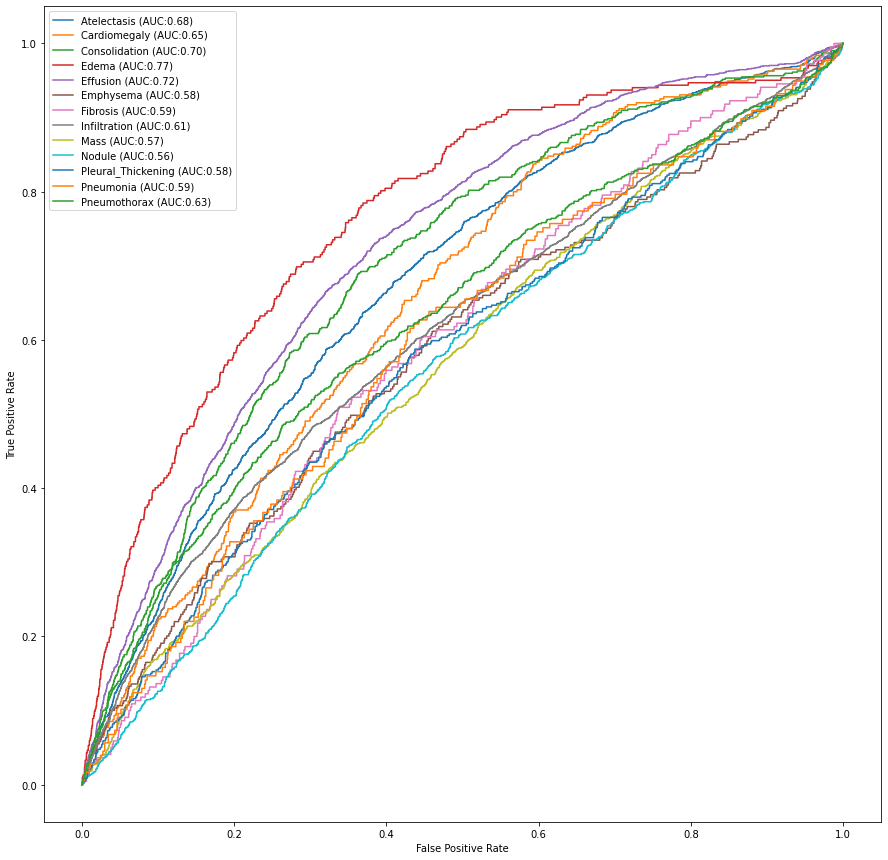

In [28]:
# Create an AUC / ROC curve 
fig, c_ax = plt.subplots(1,1, figsize = (15, 15))

# Loop through all the labels and get the index and values. 
for (idx, c_label) in enumerate(labels):
    # create variables for the roc curve based on its output.
    #The for loop loops through all the values in the list of binarized labels based on index via column of the labels
    fpr, tpr, thresholds = roc_curve(nptest_Y[:,idx].astype(int), pred_y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('/content/drive/MyDrive/NIH-CXR/Delta_model_AUCROC.png')

In [37]:
# Function to take in a dataframe of binary labels from CNN and assign Triage levels in a new column ['Triage']

def triage_classifier(df):

    copy_df = df.copy() # Creates a copy of the dataframe 
    copy_df['Triage'] = np.nan # Creates a new empty column for the triage assignment 
    
    for ind in copy_df.index: # loops through dataframe based on index
        # Emergent = Atelectasis, Consolidation, Edema, Effusion, Infiltration, Pneumothorax
        if (copy_df['Atelectasis'][ind] == 1)\
            or (copy_df['Consolidation'][ind] ==1)\
                or (copy_df['Edema'][ind] == 1)\
                    or (copy_df['Effusion'][ind] == 1)\
                        or (copy_df['Infiltration'][ind] == 1)\
                            or (copy_df['Pneumothorax'][ind] == 1):
                            copy_df['Triage'][ind] = 'Emergent'

        # Acute = Mass, Pneumonia. Hernia is ignored due to insufficient sample size.                    
        elif (copy_df['Mass'][ind] == 1) or (copy_df['Pneumonia'][ind] == 1):
            copy_df['Triage'][ind] = 'Acute'

        # Chronic = Cardiomegaly, Emphysema, Fibrosis, Nodule, Pleural Thickening 
        elif (copy_df['Cardiomegaly'][ind] == 1)\
            or (copy_df['Emphysema'][ind] ==1)\
                or (copy_df['Fibrosis'][ind] == 1)\
                    or (copy_df['Nodule'][ind] == 1)\
                        or (copy_df['Pleural_Thickening'][ind] == 1):
                        copy_df['Triage'][ind] = 'Chronic'
        # If no hits, then 'No Finding' 
        else: 
            copy_df['Triage'][ind] = 'No Finding'

    return copy_df

In [29]:
# See Predictions greater than 20% for the provisional model and save to csv
predictions = (pred_y > 0.2).astype(int)
columns=labels
#columns should be the same order of y_col
results=pd.DataFrame(predictions, columns=columns)
results["Filenames"]=test_set["Image Index"].tolist()
ordered_cols=["Filenames"]+columns
results=results[ordered_cols]#To get the same column order
results_df = triage_classifier(results)
results_df.to_csv('/content/drive/MyDrive/NIH-CXR/delta_net_predictions.csv')

print(results_df)

             Filenames  Atelectasis  Cardiomegaly  Consolidation  Edema  \
0     00026810_022.png            1             0              0      0   
1     00020936_000.png            0             0              0      0   
2     00022993_023.png            0             0              0      0   
3     00005822_004.png            1             0              0      0   
4     00011470_005.png            0             0              0      0   
...                ...          ...           ...            ...    ...   
9995  00027138_000.png            0             0              0      0   
9996  00023040_000.png            0             0              0      0   
9997  00002300_005.png            0             0              0      0   
9998  00013992_030.png            1             0              0      0   
9999  00016743_018.png            1             0              0      0   

      Effusion  Emphysema  Fibrosis  Infiltration  Mass  Nodule  \
0            1          0       

In [30]:
# Required to save models in HDF5 format
!pip install pyyaml h5py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [31]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
d_model.save('/content/drive/MyDrive/NIH-CXR/delta_model.h5') 

In [32]:
# Save Model as a JSON file 
model_json = d_model.to_json()
with open("/content/drive/MyDrive/NIH-CXR/d_model.json", "w") as json_file:
    json_file.write(model_json)

### F1 Score and Confusion Matrices for each Individual Label

In [33]:
# Import Dependencies 
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay, f1_score

In [34]:
# Calculate the F1 Score for the model for multilabel classification. Use average = 'micro'
f1_score(y_true = nptest_Y, y_pred= np.array(results[labels], dtype = int), average= 'micro')

0.3254242012473433

In [35]:
# Create the confusion matrix for each of the labels 
conf_mat = multilabel_confusion_matrix(y_true = nptest_Y, y_pred= np.array(results[labels], dtype = int))

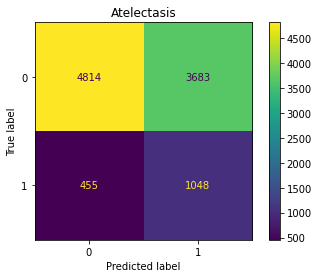

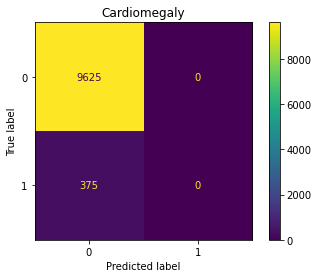

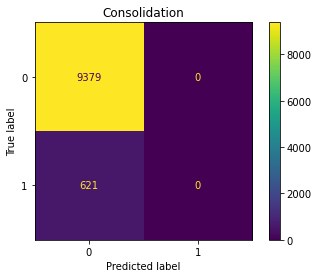

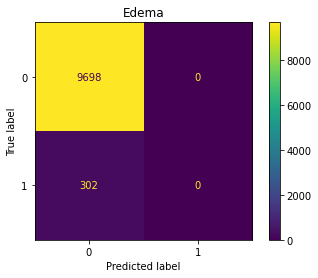

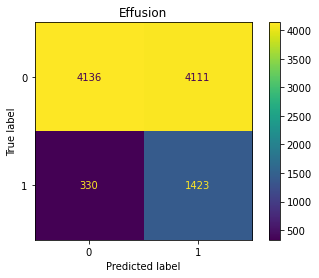

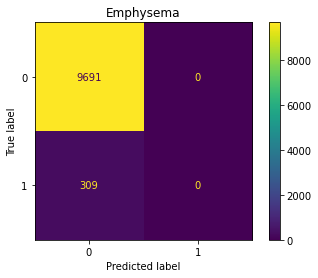

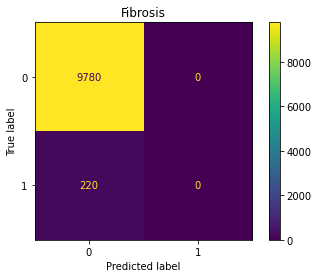

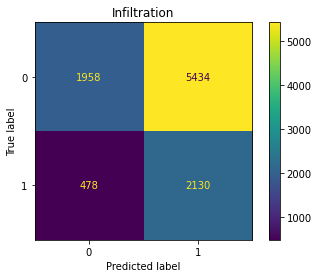

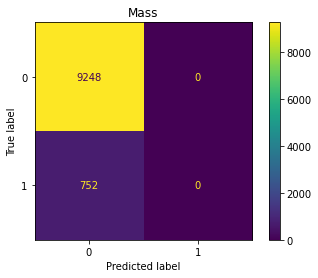

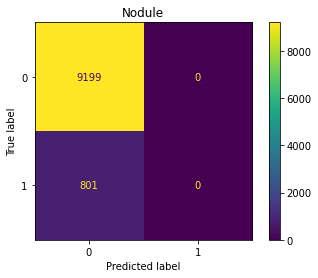

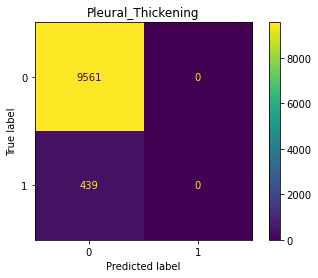

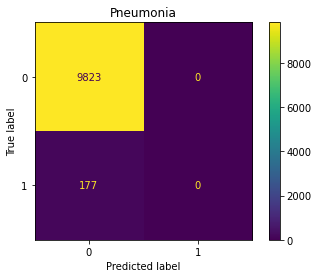

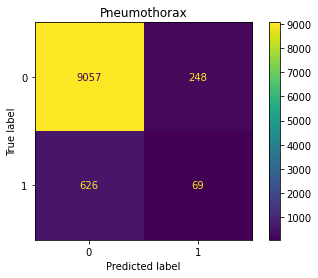

In [36]:
# Plot the individual confusion matrices for the test sample. 

for i in range(len(conf_mat)):
  disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat[i])
  disp.plot()
  plt.title(labels[i])
  plt.savefig(f"/content/drive/MyDrive/NIH-CXR/delta_cm_{labels[i]}")
  plt.show()
  